In [1]:
%load_ext autoreload
%autoreload 2

# Analyzing Wedge Range Filter Modules (WRFs)

Note: because of how ReadTheDocs works, this notebook is pre-executed

In [75]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

from cr39py.core.data import data_dir
from cr39py.core.units import u
from cr39py.scan.wrf import  WedgeRangeFilter, synthetic_wrf_data

Wrfs are...

![wrf_diagram](images/wrf_diagram.png)

The spatial coordinate system of WRF scans are absolutely aligned to the coordinate system of the filter using several fiducials which are imprinted on the CR-39 during the shot by holes in the filter which allow a high fluence of particles to pass through. The calibrated slope and offset of the WRF's linear profile are also stored in this coordiante system, making it easy to calculate the thickness of the WRF at a given x position on the scan.

The `WedgeRangeFilter` class is a subclass of `Scan`, and can be initialized directly from a CPSA file. In this case, the WRF's calibration information must also be included, either as a keyword argument or as an ID code in the filename. Calibrations for new WRFs can be added to the yaml file `cr39py/data/calibration/wrf_calibrations.yml`

WRF analysis is conducted in Diameter(X) space, and the signal is integrated over the y-axis. So, we will need to set the framesize to something smaller than the default to get a good fit.

In [92]:
example_wrf_file = data_dir / Path('test/test_wrf_G093_6hr.cpsa')
wrf = WedgeRangeFilter.from_cpsa(example_wrf_file)
print(wrf.axes['X'].framesize)
wrf.set_framesize('X', 200*u.um)
wrf.set_framesize('D', 0.1*u.um)

***CPSA header***
...Version: 104
...nx, ny microscope bins: 90, 64
...Nframes: 5760
...Pixel size: 3.3e-01 um
...Threshold: 85
...Untilized camera image px NFPx, NFPy: 1314, 962
...Microscope frame size fx, fy: 4.3e+02 um, 3.1e+02 um


Reading CPSA file: 100%|██████████| 5760/5760 [00:01<00:00, 4828.16it/s]

0.15418695


In D(x) space, we can now see the characteristic curve, sometimes called the "WRF plot". As the filter gets thicker to the right, and particles are ranged down more, the track sizes get larger. If the incoming particles were monoenergetic, the curve would be infinitely thin. The offset of the curve in the x direction corresponds to the mean energy of the incident particles.

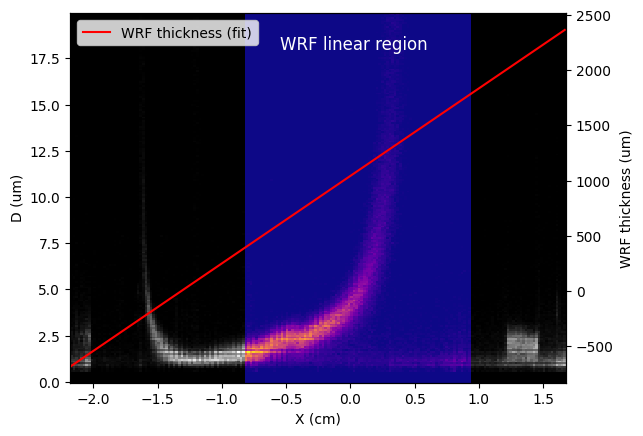

In [93]:
xax, dax, arr = wrf.histogram(axes="XD", ylim=(0,20))
# Mark where the WRF actually begins and ends: ~400 to ~1800 um thick
xa= np.argmin(np.abs(wrf.wrf_thickness - 400*u.um))
xb = np.argmin(np.abs(wrf.wrf_thickness - 1800*u.um))

fig, ax = plt.subplots()
ax.set_xlabel("X (cm)")
ax.set_ylabel("D (um)")
ax.pcolormesh(xax.m_as(u.cm), dax.m_as(u.um), arr.T, shading='auto', cmap='binary_r')
ax.pcolormesh(xax[xa:xb].m_as(u.cm), dax.m_as(u.um), arr[xa:xb, :].T, shading='auto', cmap='plasma')
ax.text(-0.55, 18, "WRF linear region", color='white', fontsize=12)

ax2 = ax.twinx()
ax2.plot(wrf.xaxis.m_as(u.cm), wrf.wrf_thickness, color='red',label='WRF thickness (fit)')
ax2.legend(loc='upper left')
ax2.set_ylabel("WRF thickness (um)");

## Selecting the tracks to analyze

The cut plot below provides several looks at the distribution of the tracks on the WRF. 

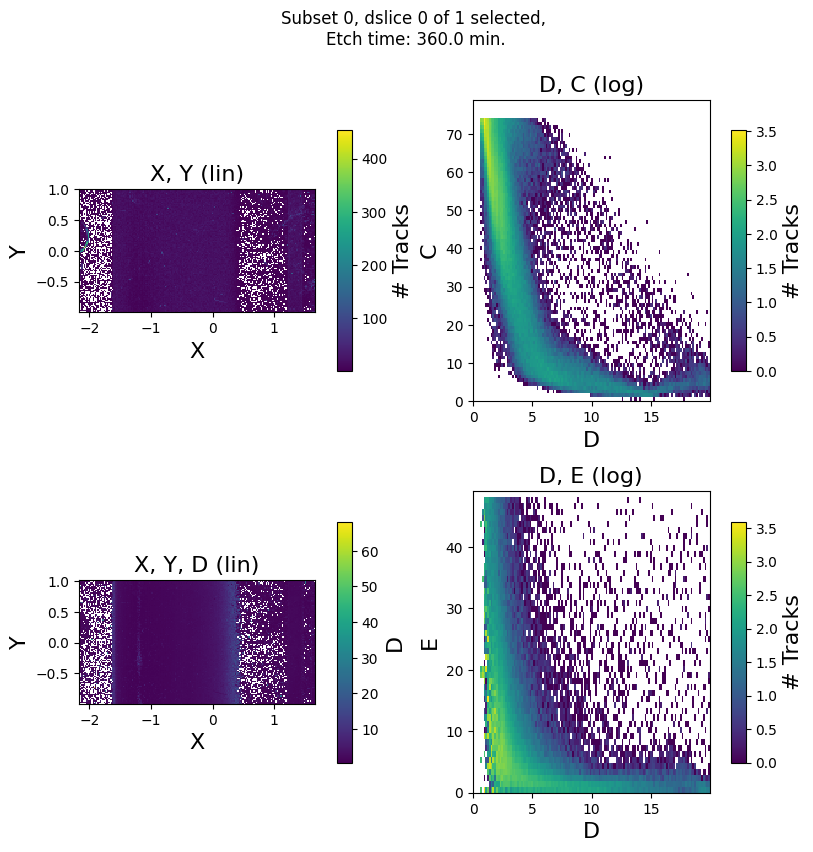

In [34]:
wrf.cutplot();

While the "WRF plot" above nicely illustrates the concept, there are several regions of tracks that should be excluded from the analysis. 

1) Only tracks in the region where the WRF is linear should be included. For the WRF in question, this is the region where the WRF thickness ranges from ~400 to ~1800 um. 
2) The C-parameter model is only valid in the region where track energy is purely a function of diameter, not contrast. This means that we should only include tracks in the flat region of the "hockey stick" curve. In this data, means something like 8 to 20 um.
3) To aggressivly minimize noise, we will cut tracks with contrast > 10, or eccentricities >15.  

The `set_limits` method of the `WedgeRangeFilter` class provides an easy interface for setting these bounds, including automatically setting the x boundary base on limits provided for the filter thickness.

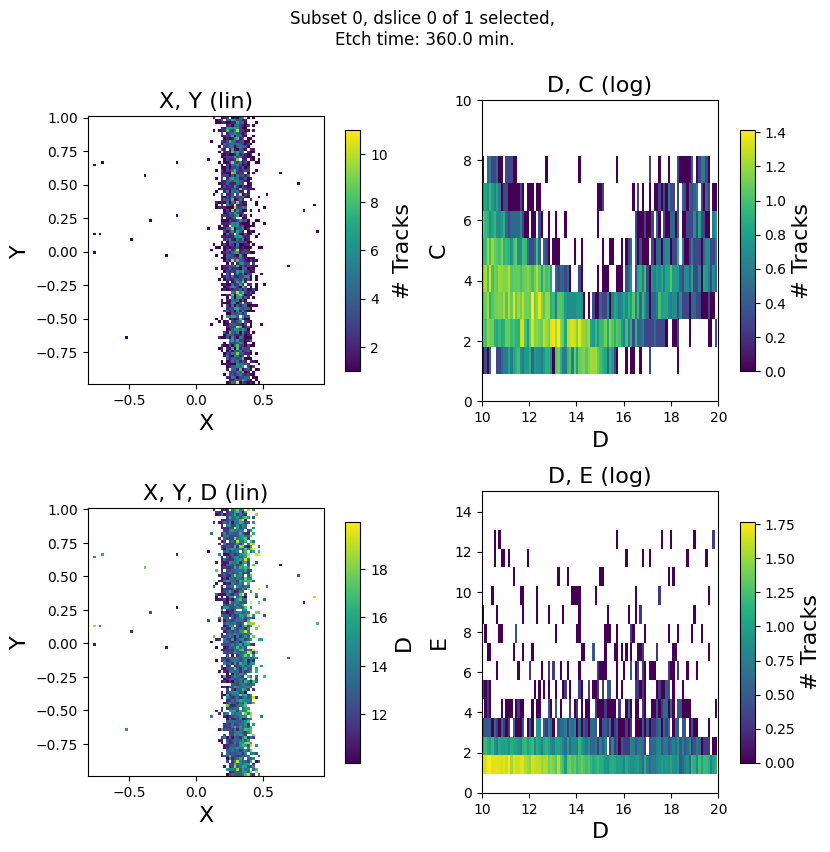

In [94]:
wrf.set_limits(trange=(100,1800), drange=(10,20), crange=(0,10), erange=(0,15))
wrf.cutplot();

Now we see that the analyzable portion of the WRF data is restricted to a single verticle line. 

None None None
[np.float64(-1.1888972520828247), np.float64(0.8911007642745972)] [np.float64(10.004940032958984), np.float64(19.90491485595703)] None


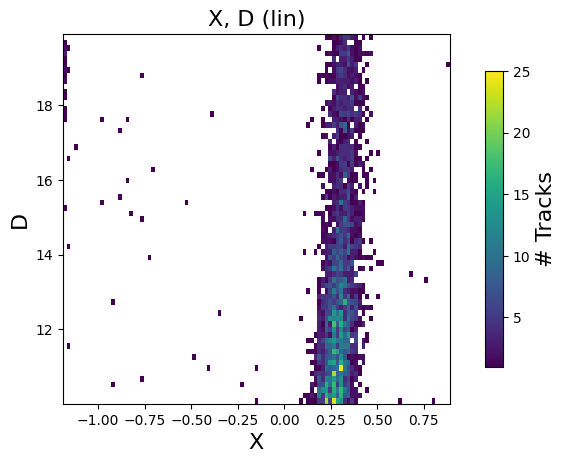

In [70]:
wrf.plot(axes='XD');

Re-examining the "WRF plot", D(x), we see that we have seemingly thrown away a large part of the data. However, since it is imperative that the data be well described by the C-parameter model, fitting this subset of the data will still actually result in a better fit than including the full curve.

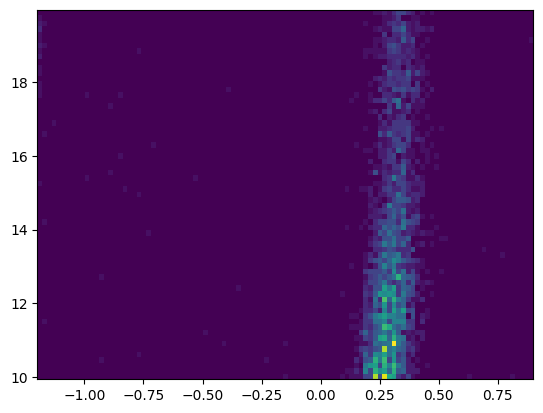

In [71]:
xax, yax, img = wrf.histogram(axes='XD')
fig, ax = plt.subplots()
ax.pcolormesh(xax, yax, img.T)

## The WRF forward model

The WRF module also contains a synthetic model for forward-modeling WRF data, which we will use to fit the data. The forward model assumes that the incident particles have a Gaussian energy distribution, and that the response of the CR-39 follows the c-Parameter model. There are four parameters: 

- The mean and std of the incident particle energy distribution
- The c and dmax parameters of the c-Parameter model

Synthetic data is created by:

1) Using the c-parameter model to translate the diameter axis into an axis of incident particle energy on the front of the CR-39.
2) Using an interpolator constructed on SRIM ranging data, and the WRF thickness at each x value, translate each pixel in X,D space into an incident energy on the front of the WRF. 
3) Model the normalized fluence on that pixel as a Gaussian with the given parameters.

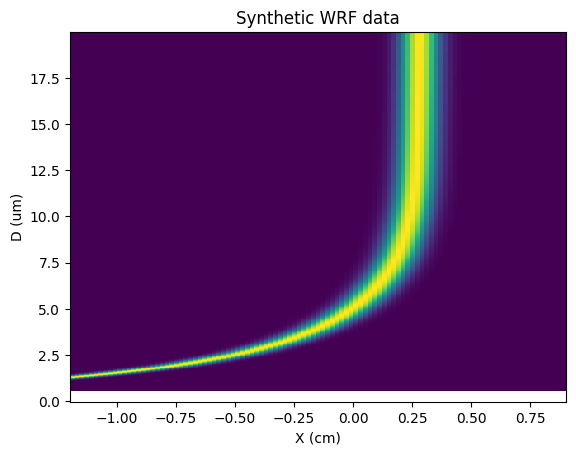

In [88]:
params = (15, 0.3, 1.2, 20) # Mean energy, energy standard deviation, c-parameter, dmax parameter
xaxis = wrf.xaxis.m_as(u.cm)
daxis = np.arange(0, 20, 0.05)

img = synthetic_wrf_data(params, xaxis, daxis, wrf_calibration=wrf.wrf_calibration)

fig, ax = plt.subplots()
ax.set_xlabel("X (cm)")
ax.set_ylabel("D (um)")
ax.set_title("Synthetic WRF data")
ax.pcolormesh(xaxis, daxis, img.T); 


## Fitting the data

Once the appropriate limits have been found, the data can be fit with a simple call to the `fit` method. This method uses a differential evolution algorithm to perform a forward fit of the data to minimize the $\chi^2$ between the synthetic image and the data.



Emean: 15.15
Estd: 0.59
c-parameter: 0.80
dmax-parameter: 16.28


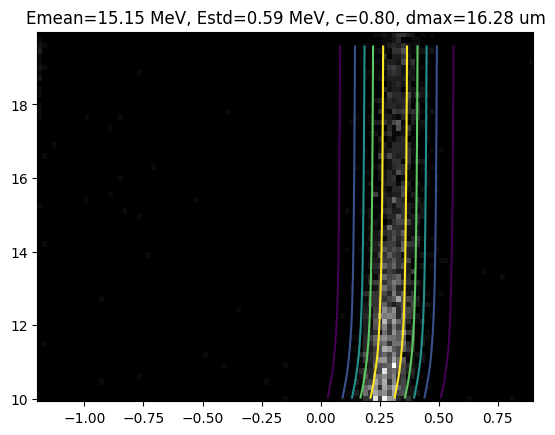

In [91]:
guess = (15, 0.1, 1.5, 20) # Mean energy, energy standard deviation, c-parameter, dmax parameter
bounds = [(12, 17), (0.05, 2), (0.4, 2), (16, 22)]
res = wrf.fit(guess, bounds=bounds, plot=True);

for i,name in enumerate(['Emean', 'Estd', 'c-parameter', 'dmax-parameter']):
    print(f"{name}: {res[i]:.2f}")
